# GRMHD Movie Analysis
---
Analyse GRMHD movies

[2] https://github.com/aviadlevis/pynoisy

In [2]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
import xarray as xr

In [3]:
def resample_movie(movie, initial_frame, nt, nx, ny):
    assert initial_frame >= 0, 'Negative initial frame'
    assert (initial_frame + nt) < movie.t.size, 'Final frame: {} out of bounds for input of length: {}'.format(
        initial_frame + nt, movie.t.size)
    movie = movie[initial_frame:initial_frame + nt].interp_like(pynoisy.utils.get_grid(nx, ny))
    movie.attrs.update({'initial_frame': initial_frame})
    return movie

def random_center(measurements):
    measurements = measurements.fillna(0.0)
    measurements.loc[{'x': 0, 'y':0}] = np.random.randn(measurements.t.size)
    return measurements

def objective_fun(x, solver, measurements, degree, mask=None, n_jobs=4):
    solver.update_diffusion(pynoisy.diffusion.general_xy(solver.nx, solver.ny, opening_angle=x))
    error = krylov_error_fn(solver, measurements, degree, mask, n_jobs)
    if mask is None:
        loss = (error**2).mean()
    else:
        loss = (error.where(mask)**2).mean()
    return np.array(loss)

def krylov_error_fn(solver, measurements, degree, mask, n_jobs):
    krylov = solver.run(source=measurements, nrecur=degree, verbose=0, std_scaling=False, n_jobs=n_jobs)
    
    # Masked (pixels) krylov or loss over all pixels
    if mask is None:
        k_matrix = krylov.data.reshape(degree, -1)
        result = np.linalg.lstsq(k_matrix.T, np.array(measurements).ravel(), rcond=-1)
        coefs, residual = result[0], result[1]
        random_field = np.dot(coefs.T, k_matrix).reshape(*measurements.shape)
    else: 
        k_matrix = krylov.data[...,mask].reshape(degree, -1)
        result = np.linalg.lstsq(k_matrix.T, measurements.data[...,mask].ravel(), rcond=-1)
        coefs, residual = result[0], result[1]
        random_field = xr.full_like(measurements, fill_value=np.nan)
        random_field.values[mask] = np.dot(coefs.T, k_matrix)
        
    error = random_field - measurements
    return error

## Load GRMHD Movie

In [4]:
directory = '../../GRMHD/'
slider = pynoisy.utils.slider_select_file(directory, filetype='h5')

interactive(children=(IntSlider(value=2, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

In [87]:
"""
Crop temporal axis and rescale spatial axis

Notes
-----
Ma+0.5_inc10.h5: initial_frame = 400 
Ma0_inc10.h5: initial_frame = 500
Ma+0.94_inc10.h5: initial_frame = 600
"""
measurements = pynoisy.utils.load_grmhd(slider.result)
model_name = slider.result.split('/')[-1][:-3]

initial_frame = 400
nt, nx, ny = 64, 256, 256
measurements_scaled = resample_movie(measurements, initial_frame, nt, nx, ny)

<IPython.core.display.Javascript object>


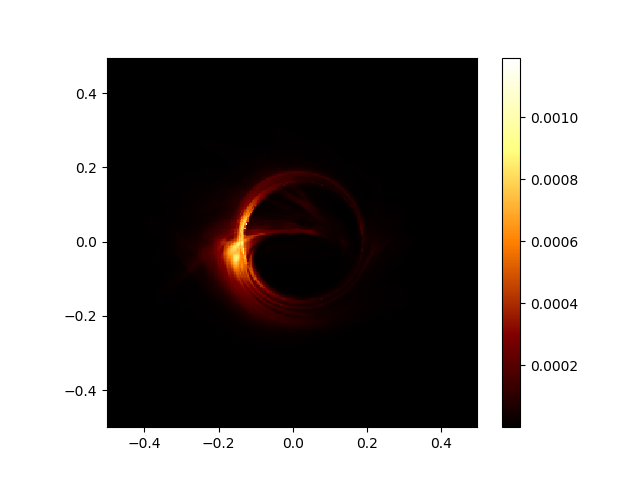

In [89]:
%matplotlib notebook
output_gif = slider.result[:-3] + '_cropped_initial_frame{}_{}x{}x{}.gif'.format(initial_frame, nt, nx, ny)
measurements_scaled.noisy_methods.get_animation(output=output_gif)

In [92]:
"""
Generate GRF-like measurements from the input GRMHD movie
"""
mask = np.sqrt(measurements_scaled.x**2 + measurements_scaled.y**2) > 0.08
measurements_grf = np.log(measurements_scaled)
measurements_grf = measurements_grf - measurements_grf.mean('t')

In [93]:
%matplotlib notebook
animation = measurements_grf.noisy_methods.get_animation(vmin=-2, vmax=2, cmap='viridis')

<IPython.core.display.Javascript object>

In [94]:
"""
Save animation
"""
output_gif = slider.result[:-3] + '_cropped_initial_frame{}_{}x{}x{}_grflike.gif'.format(initial_frame, nt, nx, ny)
animation.save(output_gif, writer='imagemagick')

## Diffusion opening angle

---
Estimate the opening angle for CW rotation. Plot the 1D Krylov loss function

In [124]:
krylov_degree = 8
advection = pynoisy.advection.general_xy(nx, ny, direction='cw')
diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=-1.2)
solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion)

theta_grid = np.linspace(-0.5*np.pi, 0.5*np.pi, 50)
measurements_grf_rand = random_center(measurements_grf)
results = [objective_fun(x, solver, measurements_grf_rand, degree=krylov_degree, mask=None) for x in tqdm(theta_grid)]
loss = np.array(results)

<IPython.core.display.Javascript object>


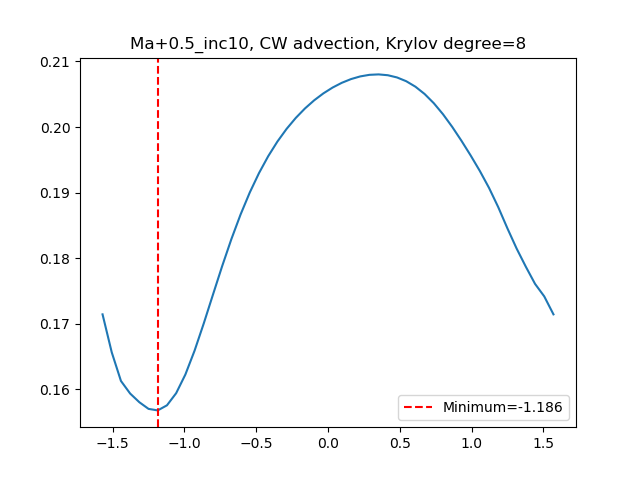

In [125]:
%matplotlib notebook
minima = theta_grid[np.argmin(loss)]
plt.plot(theta_grid, loss)
plt.axvline(x=minima, label='Minimum={:1.4}'.format(minima), color='r', linestyle='--')
plt.title('{}, CW advection, Krylov degree={}'.format(model_name, krylov_degree))
plt.legend()

<IPython.core.display.Javascript object>


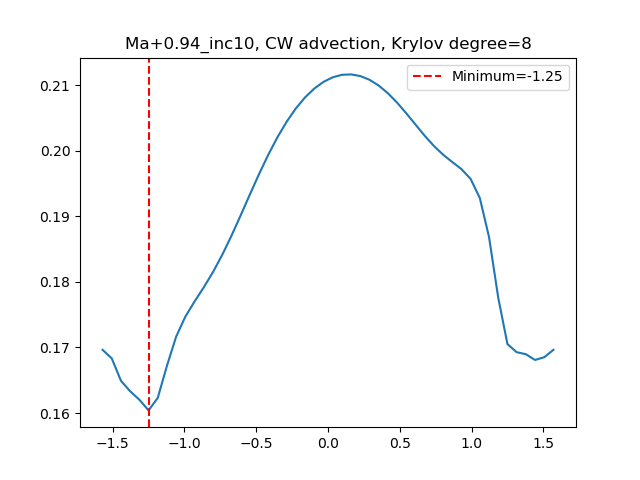

In [115]:
%matplotlib notebook
minima = theta_grid[np.argmin(loss)]
plt.plot(theta_grid, loss)
plt.axvline(x=minima, label='Minimum={:1.4}'.format(minima), color='r', linestyle='--')
plt.title('{}, CW advection, Krylov degree={}'.format(model_name, krylov_degree))
plt.legend()